In [1]:
import laspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf

from tqdm import tqdm

import warnings
warnings.simplefilter("ignore")

# Exploration of the dataset

In [2]:
las = laspy.read('../donnees/LHD_FXX_0235_6834_PTS_C_LAMB93_IGN69.copc.laz')

In [3]:
print(f"Point format:       {las.header.point_format}")
print(f"Number of points:   {las.header.point_count}")
print(f"Number of vlrs:     {len(las.header.vlrs)}")

Point format:       <PointFormat(6, 0 bytes of extra dims)>
Number of points:   29811413
Number of vlrs:     2


In [4]:
df = pd.DataFrame(las.points.array, columns=list(las.point_format.dimension_names))

In [5]:
df.head()

,X,Y,Z,intensity,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,edge_of_flight_line,classification,user_data,scan_angle,point_source_id,gps_time
0,23503027,683318829,25657,4305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,2958,88,3.602434e+08
1,23502874,683318806,25670,3952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,2958,88,3.602434e+08
2,23503081,683318983,25661,3626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,2967,88,3.602434e+08
3,23502688,683318764,25686,3946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,2957,88,3.602434e+08
4,23502730,683318818,25687,4113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,2958,88,3.602434e+08


In [6]:
df.describe()

,X,Y,Z,intensity,classification,user_data,scan_angle,point_source_id,gps_time
count,2.981141e+07,2.981141e+07,2.981141e+07,2.981141e+07,2.981141e+07,29811413.0,2.981141e+07,2.981141e+07,2.981141e+07
mean,2.355006e+07,6.833478e+08,2.621907e+04,1.507720e+03,3.477446e+00,0.0,-1.328111e+02,8.638310e+01,3.602452e+08
std,2.766448e+04,2.842053e+04,9.916993e+02,1.506110e+03,1.530183e+00,0.0,2.001018e+03,8.880250e-01,8.562649e+02
min,2.350000e+07,6.833000e+08,2.400100e+04,4.600000e+01,1.000000e+00,0.0,-3.336000e+03,8.500000e+01,3.602434e+08
25%,2.352640e+07,6.833216e+08,2.546400e+04,1.930000e+02,2.000000e+00,0.0,-1.903000e+03,8.600000e+01,3.602449e+08
50%,2.355090e+07,6.833501e+08,2.627600e+04,7.130000e+02,3.000000e+00,0.0,-3.200000e+02,8.600000e+01,3.602452e+08
75%,2.357253e+07,6.833713e+08,2.696100e+04,2.983000e+03,5.000000e+00,0.0,1.660000e+03,8.700000e+01,3.602452e+08
max,2.360000e+07,6.834000e+08,2.935300e+04,1.221300e+04,6.700000e+01,0.0,3.325000e+03,8.800000e+01,3.602467e+08


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29811413 entries, 0 to 29811412
Data columns (total 18 columns):
 #   Column               Dtype  
---  ------               -----  
 0   X                    int32  
 1   Y                    int32  
 2   Z                    int32  
 3   intensity            uint16 
 4   return_number        object 
 5   number_of_returns    object 
 6   synthetic            object 
 7   key_point            object 
 8   withheld             object 
 9   overlap              object 
 10  scanner_channel      object 
 11  scan_direction_flag  object 
 12  edge_of_flight_line  object 
 13  classification       uint8  
 14  user_data            uint8  
 15  scan_angle           int16  
 16  point_source_id      uint16 
 17  gps_time             float64
dtypes: float64(1), int16(1), int32(3), object(9), uint16(2), uint8(2)
memory usage: 2.8+ GB


In [8]:
df.isnull().sum()/df.shape[0]

X                      0.0
Y                      0.0
Z                      0.0
intensity              0.0
return_number          1.0
number_of_returns      1.0
synthetic              1.0
key_point              1.0
withheld               1.0
overlap                1.0
scanner_channel        1.0
scan_direction_flag    1.0
edge_of_flight_line    1.0
classification         0.0
user_data              0.0
scan_angle             0.0
point_source_id        0.0
gps_time               0.0
dtype: float64

In [9]:
df_na_dropped = df.dropna(axis=1, how='all')

In [10]:
df_na_dropped.isnull().sum()/df_na_dropped.shape[0]

X                  0.0
Y                  0.0
Z                  0.0
intensity          0.0
classification     0.0
user_data          0.0
scan_angle         0.0
point_source_id    0.0
gps_time           0.0
dtype: float64

In [11]:
sample_df = df_na_dropped.sample(500000)

In [12]:
sample_df = sample_df[['X', 'Y', 'Z', 'intensity', 'scan_angle', 'classification']]
# F. Patricia Medina and Randy Paffenroth use the return_number and number_of_returns variables but we only have nan values for these variables in ou dataset.

# Preprocessing of the dataset and feature engineering

In [13]:
X = sample_df.drop('classification', axis=1)

In [14]:
Y = sample_df['classification']

In [15]:
np.random.seed(42)
X_coordinates = X[['X', 'Y', 'Z']]

# Number of neighbors to consider
k_neighbors = 16 # 15 neighbors + the point itself

In [16]:
# Fit a Nearest Neighbors model on your data
nn_model = NearestNeighbors(n_neighbors=k_neighbors, metric='euclidean')
nn_model.fit(X_coordinates)

NearestNeighbors(metric='euclidean', n_neighbors=16)

In [17]:
# Function to find the k-nearest neighbors for each sample and concatenate their features
def find_and_concat_neighbors(row):
    distances, indices = nn_model.kneighbors([row])
    neighbor_features = X.iloc[indices[0]].values.flatten()
    return pd.Series(neighbor_features)

In [19]:
tqdm.pandas()
result_X_coordinates = X_coordinates.progress_apply(find_and_concat_neighbors, axis=1)

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [04:20<00:00, 1922.84it/s]


In [20]:
result_X_coordinates.shape

(500000, 80)

In [21]:
result_X_coordinates.columns = np.array([[f'{j}_{i}' for j in X.columns] for i in range(k_neighbors)]).flatten()

In [22]:
result_X_coordinates

,X_0,Y_0,Z_0,intensity_0,scan_angle_0,X_1,Y_1,Z_1,intensity_1,scan_angle_1,...,X_14,Y_14,Z_14,intensity_14,scan_angle_14,X_15,Y_15,Z_15,intensity_15,scan_angle_15
21478638,23531244,683315434,24223,1824,-2760,23531283,683315379,24222,1596,-2682,...,23531310,683315145,24203,1713,2766,23531483,683315248,24208,1625,-2770
80122,23514718,683357940,27104,3397,-2228,23514468,683357964,27124,4127,-563,...,23514396,683358245,27109,4959,3325,23514273,683357908,27142,3136,-2228
20952062,23521539,683379481,27670,738,-3299,23521464,683379443,27599,327,2317,...,23521408,683379291,27401,1749,2321,23521262,683379304,27507,1821,2324
16395898,23569742,683324234,25730,1567,3208,23569621,683324198,25845,252,-496,...,23570049,683324330,25972,917,3219,23570068,683324363,25961,76,3222
29295993,23513909,683345528,27324,3561,-1622,23513971,683345574,27324,3297,-1598,...,23513631,683345876,27343,4009,-1197,23513501,683345301,27335,2693,-1611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24268942,23556295,683346863,24756,79,-1662,23556267,683346824,24749,1362,-1086,...,23556060,683347276,24750,675,-1062,23555978,683347128,24993,219,-1662
9243740,23509969,683337829,27070,4023,-1614,23509901,683337893,27075,3978,-1190,...,23510127,683337470,27049,3389,-1210,23509874,683338252,27097,3707,-1210
443033,23537691,683364852,25661,4171,-305,23537592,683364922,25660,3759,2994,...,23537676,683365306,25664,4853,2979,23538125,683364705,25663,4475,3005
11642033,23526173,683330718,25820,602,-1945,23526328,683330833,25803,2215,-1938,...,23526293,683330483,26162,169,-814,23526278,683330404,26122,106,-825


In [23]:
scaler = StandardScaler()
standardized_X = scaler.fit_transform(result_X_coordinates)

In [24]:
normalizer = Normalizer()
normalized_X = normalizer.fit_transform(standardized_X)

In [25]:
pca = PCA(n_components=40)
final_X = pca.fit_transform(result_X_coordinates)
# print(pca.explained_variance_ratio_)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    final_X, Y, test_size=0.1, random_state=42)

## RandomForestClassifier

### Initialize and train model

In [27]:
clf = RandomForestClassifier(max_depth=20)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20)

### Check prediction quality of the model

In [28]:
y_hat = clf.predict(X_test)

In [29]:
cm = confusion_matrix(y_test, y_hat)

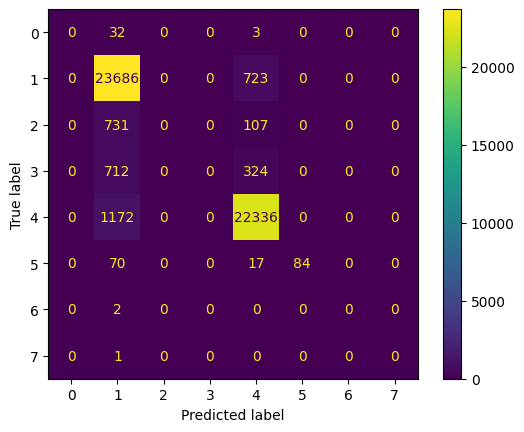

In [30]:
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [31]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        35
           2       0.90      0.97      0.93     24409
           3       0.00      0.00      0.00       838
           4       0.00      0.00      0.00      1036
           5       0.95      0.95      0.95     23508
           6       1.00      0.49      0.66       171
          65       0.00      0.00      0.00         2
          67       0.00      0.00      0.00         1

    accuracy                           0.92     50000
   macro avg       0.36      0.30      0.32     50000
weighted avg       0.89      0.92      0.90     50000



## Deep neural network

### Initialize model

In [32]:
y_train = y_train.apply(lambda x: x-1 if x<60  else (6 if x==65 else 7))
y_test = y_test.apply(lambda x: x-1 if x<60 else (6 if x==65 else 7))

In [33]:
num_classes=8
epochnum = 50
batch_size = 32
val_split = 0.2
LR=1e-3

def custom_LearningRate_schedular(epoch, learning_rate=1e-3, max_epoch=epochnum, power=0.9):
    new_lr = learning_rate * tf.math.pow((1 - epoch/max_epoch), power)
    print(f"learning rate : {new_lr}")
    return new_lr

callbacks = [
    tf.keras.callbacks.LearningRateScheduler(custom_LearningRate_schedular),
    tf.keras.callbacks.EarlyStopping(patience=10, start_from_epoch=10)
]


# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(final_X.shape[1],)),  # Input layer
    tf.keras.layers.Dense(20, kernel_regularizer='l2', activation='relu'),  # First hidden layer with 20 units and ReLU activation
    tf.keras.layers.Dense(15, kernel_regularizer='l2', activation='relu'),  # Second hidden layer with 15 units and ReLU activation
    tf.keras.layers.Dense(num_classes, activation='softmax') # Output layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 15)                315       
                                                                 
 dense_2 (Dense)             (None, 8)                 128       
                                                                 
Total params: 1263 (4.93 KB)
Trainable params: 1263 (4.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train model

In [35]:
# Train the model
history = model.fit(X_train, y_train, epochs=epochnum, batch_size=batch_size, validation_split=val_split)

Epoch 1/50
11250/11250 [==============================] - 13s 1ms/step - loss: 84.2815 - accuracy: 0.6864 - val_loss: 1.0697 - val_accuracy: 0.5926
Epoch 2/50
11250/11250 [==============================] - 12s 1ms/step - loss: 0.8901 - accuracy: 0.6607 - val_loss: 0.7725 - val_accuracy: 0.7175
Epoch 3/50
11250/11250 [==============================] - 12s 1ms/step - loss: 0.6129 - accuracy: 0.8155 - val_loss: 0.3812 - val_accuracy: 0.9124
Epoch 4/50
11250/11250 [==============================] - 13s 1ms/step - loss: 0.4793 - accuracy: 0.8730 - val_loss: 0.3384 - val_accuracy: 0.9170
Epoch 5/50
11250/11250 [==============================] - 13s 1ms/step - loss: 0.3491 - accuracy: 0.9112 - val_loss: 0.3208 - val_accuracy: 0.9183
Epoch 6/50
11250/11250 [==============================] - 13s 1ms/step - loss: 0.3284 - accuracy: 0.9135 - val_loss: 0.3146 - val_accuracy: 0.9160
Epoch 7/50
11250/11250 [==============================] - 14s 1ms/step - loss: 0.3314 - accuracy: 0.9130 - val_loss: 

### Evaluate prediction quality of the model

In [36]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

1563/1563 [==============================] - 1s 885us/step - loss: 0.3181 - accuracy: 0.9137
Test Accuracy: 91.37%


In [37]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# # Decode integer labels back to original class labels
# y_test_original = label_encoder.inverse_transform(y_test_encoded)
# y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Display classification report
print(classification_report(y_test, y_pred_classes))

1563/1563 [==============================] - 1s 748us/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.88      0.97      0.92     24409
           2       0.00      0.00      0.00       838
           3       0.00      0.00      0.00      1036
           4       0.95      0.93      0.94     23508
           5       0.00      0.00      0.00       171
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1

    accuracy                           0.91     50000
   macro avg       0.23      0.24      0.23     50000
weighted avg       0.88      0.91      0.89     50000



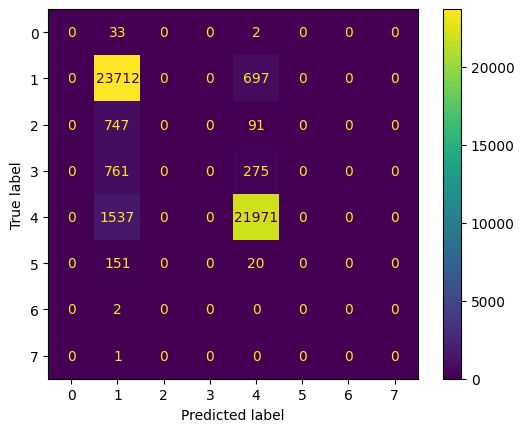

In [38]:
cm = confusion_matrix(y_test, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

## Resampling to try to mitigate effect of unbalanced dataset

In [39]:
y_train.value_counts()

classification
1    220649
4    211171
3      8889
2      7531
5      1474
0       271
6         8
7         7
Name: count, dtype: int64

In [40]:
X_train_0 = X_train[(y_train == 0).values]
X_train_1 = X_train[(y_train == 1).values]
X_train_2 = X_train[(y_train == 2).values]
X_train_3 = X_train[(y_train == 3).values]
X_train_4 = X_train[(y_train == 4).values]
X_train_5 = X_train[(y_train == 5).values]
X_train_6 = X_train[(y_train == 6).values]
X_train_7 = X_train[(y_train == 7).values]

In [41]:
y_train_0 = y_train[(y_train == 0).values]
y_train_1 = y_train[(y_train == 1).values]
y_train_2 = y_train[(y_train == 2).values]
y_train_3 = y_train[(y_train == 3).values]
y_train_4 = y_train[(y_train == 4).values]
y_train_5 = y_train[(y_train == 5).values]
y_train_6 = y_train[(y_train == 6).values]
y_train_7 = y_train[(y_train == 7).values]

In [42]:
idx = np.random.randint(0, len(X_train_2), 1500)
X_train_2 = X_train_2[idx]
y_train_2 = y_train_2.iloc[idx]

idx = np.random.randint(0, len(X_train_3), 1500)
X_train_3 = X_train_3[idx]
y_train_3 = y_train_3.iloc[idx]

idx = np.random.randint(0, len(X_train_4), 1500)
X_train_4 = X_train_4[idx]
y_train_4 = y_train_4.iloc[idx]

idx = np.random.randint(0, len(X_train_1), 1500)
X_train_1 = X_train_1[idx]
y_train_1 = y_train_1.iloc[idx]

In [43]:
resampled_features = np.concatenate([X_train_0, X_train_1, X_train_2, X_train_3, X_train_4, X_train_5, X_train_6, X_train_7], axis=0)
resampled_labels = np.concatenate([y_train_0, y_train_1, y_train_2, y_train_3, y_train_4, y_train_5, y_train_6, y_train_7], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(7760, 40)

In [44]:
pd.Series(resampled_labels).value_counts()

4    1500
3    1500
2    1500
1    1500
5    1474
0     271
6       8
7       7
Name: count, dtype: int64

In [45]:
num_classes=8
epochnum = 50
batch_size = 32
val_split = 0.2
LR=1e-3


callbacks = [
    # tf.keras.callbacks.LearningRateScheduler(custom_LearningRate_schedular),
    tf.keras.callbacks.EarlyStopping(patience=20, start_from_epoch=20)
]


# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(final_X.shape[1],)),  # Input layer
    tf.keras.layers.Dense(20, kernel_regularizer='l2', activation='relu'),  # First hidden layer with 20 units and ReLU activation
    tf.keras.layers.Dense(15, kernel_regularizer='l2', activation='relu'),  # Second hidden layer with 15 units and ReLU activation
    tf.keras.layers.Dense(num_classes, activation='softmax') # Output layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [46]:
# Train the model
history = model.fit(resampled_features, pd.Series(resampled_labels), epochs=100, batch_size=32, validation_split=0.2)#, class_weight=dict(zip(np.unique(y_train), class_weights.round(4))))

Epoch 1/100
194/194 [==============================] - 1s 2ms/step - loss: 3594.0083 - accuracy: 0.2867 - val_loss: 776.3781 - val_accuracy: 0.3640
Epoch 2/100
194/194 [==============================] - 0s 1ms/step - loss: 581.3692 - accuracy: 0.3773 - val_loss: 445.9157 - val_accuracy: 0.3183
Epoch 3/100
194/194 [==============================] - 0s 1ms/step - loss: 389.5414 - accuracy: 0.4196 - val_loss: 308.0770 - val_accuracy: 0.4568
Epoch 4/100
194/194 [==============================] - 0s 1ms/step - loss: 288.2457 - accuracy: 0.4409 - val_loss: 247.5254 - val_accuracy: 0.4375
Epoch 5/100
194/194 [==============================] - 0s 1ms/step - loss: 235.4704 - accuracy: 0.4630 - val_loss: 174.9812 - val_accuracy: 0.4671
Epoch 6/100
194/194 [==============================] - 0s 1ms/step - loss: 197.9753 - accuracy: 0.4752 - val_loss: 182.0467 - val_accuracy: 0.4936
Epoch 7/100
194/194 [==============================] - 0s 1ms/step - loss: 165.5967 - accuracy: 0.4939 - val_loss: 15

In [47]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Display classification report
print(classification_report(y_test, y_pred_classes))

1563/1563 [==============================] - 1s 739us/step
              precision    recall  f1-score   support

           0       0.00      0.29      0.00        35
           1       0.90      0.45      0.60     24409
           2       0.04      0.15      0.06       838
           3       0.06      0.40      0.10      1036
           4       0.98      0.69      0.81     23508
           5       0.14      0.87      0.24       171
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1

    accuracy                           0.56     50000
   macro avg       0.26      0.36      0.23     50000
weighted avg       0.90      0.56      0.68     50000



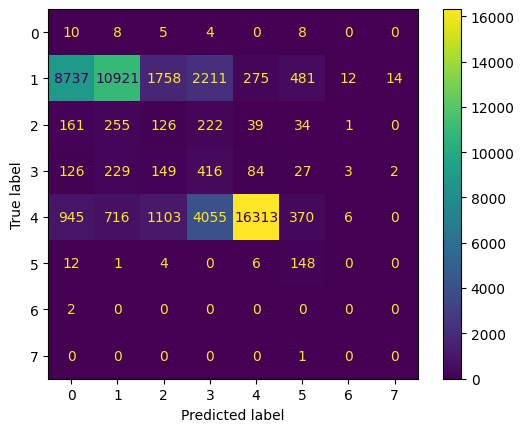

In [48]:
cm = confusion_matrix(y_test, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

In [49]:
clf = RandomForestClassifier(max_depth=20)
clf.fit(resampled_features, pd.Series(resampled_labels))

RandomForestClassifier(max_depth=20)

In [50]:
y_hat = clf.predict(X_test)

In [51]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.14      0.03      0.05        35
           1       0.99      0.67      0.80     24409
           2       0.06      0.47      0.10       838
           3       0.09      0.52      0.15      1036
           4       0.99      0.84      0.91     23508
           5       0.55      0.96      0.70       171
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1

    accuracy                           0.74     50000
   macro avg       0.35      0.44      0.34     50000
weighted avg       0.95      0.74      0.82     50000



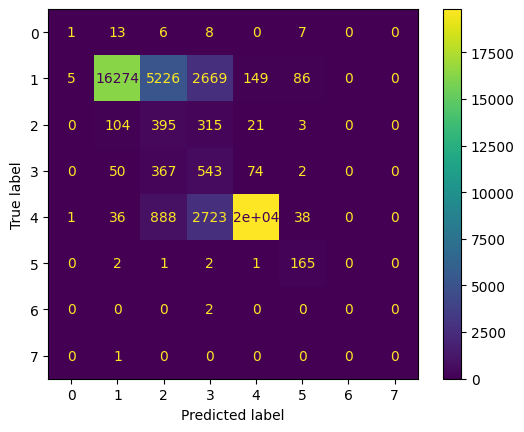

In [52]:
cm = confusion_matrix(y_test, y_hat)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()